<a href="https://colab.research.google.com/github/031wnstjd/Deep-Learning/blob/master/DL_06_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL_06 - Classification

In [ ]:
name = input("Name :")
ID = input("student ID :")

Name :추준성
student ID :2016145028


## 실습  
### 3-layer MLP for classification
CIFAR10 dataset을 classification하기 위한 3 layer MLP를 **pytorch**(class)로 구현하시오</br>

batch 단위로 학습한 결과를 15 epoch마다 출력(print)하고, 매 epoch마다의 모델의 test accuracy를 plot하시오</br>


```
hyperparameter : 
epoch_size = 50
batch_size = 128
learning_rate = 1e-3
첫 번째 hidden layer 개수 = 100
두 번째 hidden layer 개수 = 50 
모든 hidden layer는 bias 포함


```
```조건 : output layer를 제외한 모든 layer의 activation function은 relu를 사용. 모든 연산은 GPU이용```</br></br></br>


### Data

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose( # 학습하기 좋은 형태로 변환
    [transforms.ToTensor(), #이미지를 tensor자료형으로 변환
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # 정규화

In [ ]:
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, # 학습할 때 batch_size 개수만큼 학습 데이터를 리턴해주는 DataLoader를 사용
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2) # 테스트할 때 batch_size 개수만큼 테스트 데이터를 리턴해주는 DataLoader를 사용

Files already downloaded and verified
Files already downloaded and verified


### 3-layer MLP

In [ ]:
import torch.nn as nn
import numpy as np

In [ ]:
class Net(nn.Module): # nn.Module을 꼭 써줘야 함
    def __init__(self,input_size, hidden_size_1, hidden_size_2, output_size):
        super(Net,self).__init__() # 이 또한 꼭 써줘야함(클래스 상속과 관련)

        self.fc1 = nn.Linear(input_size, hidden_size_1) # nn.Linear를 정의하게 되면, fc1에 input x를 넣게 되면 자동으로 output을 출력해줌
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2) # nn.Linear를 사용하게 되면 자동으로 초기 weight와 bias를 지정해줌
        self.fc3 = nn.Linear(hidden_size_2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x): # 데이터를 입력 받아서 foraward propagation진행 -> 자동호출 method
        
        x = self.fc1(x)
        x = self.relu(x) # torch.nn 라이브러리를 사용하게 되면 따로 변수를 각기 다르게 지정해주어 중간값을 기억하지 않아도 됨
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        # softmax 함수를 따로 구현하지 않아도 됨. 향후 사용하게 될 nn.CrossEntropyLoss() 함수에 crossentropy와 softmax 기능이 내장되어 있기 때문. 
        return x

In [ ]:
hidden_size_1 = 100 # hidden layer의 weight의 개수
hidden_size_2 = 50
output_size = 10 # output target 종류의 개수 

net = Net(3072, hidden_size_1, hidden_size_2, output_size) # 모델 net 초기화(flatten 과정 포함 : 3072 = 3*32*32)

In [ ]:
import torch.optim as optim

learning_rate = 1e-3

criterion = nn.CrossEntropyLoss() # loss
optimizer = optim.SGD(net.parameters(), lr=learning_rate) #weight와 bias를 update해주는 function (net.parameters()는 변수들을 딕셔너리 형태로 저장)

### Training

In [ ]:
epoch_size = 50 # 반복 횟수 

for epoch in range(epoch_size):
  for i, (inputs, target) in enumerate(trainloader): 
    print("input shape of 1-iteration : ",inputs.shape) #[batch,channel,H,W]
    print("target shape of 1-iteration : ",target.shape) #[batch]
    print("===========================")
    reshape_input = inputs.reshape(inputs.shape[0],-1)
    print("reshape input data for mlp : ",reshape_input.shape)

    
    if i == 0 :
      break
  if epoch ==0 : 
    break

input shape of 1-iteration :  torch.Size([128, 3, 32, 32])
target shape of 1-iteration :  torch.Size([128])
reshape input data for mlp :  torch.Size([128, 3072])


In [ ]:
history = {'val_acc': []}

net.cuda() #gpu연산(네트워크 전체를 cuda로 올려줌)

for epoch in range(epoch_size):
  net.train() # weight&bias를 update할 수 있는 상태로 변환 (training하기에 앞서 무조건적으로, 습관적으로 적어줘야 함)
  total_loss = 0.0
  for i, (inputs, targets) in enumerate(trainloader): # enumerate 함수를 사용하면 인덱스 값(=i)과 return 값(=(inputs, targets))을 동시에 받을 수 있다
    inputs = inputs.cuda() #gpu연산
    targets = targets.cuda() #gpu연산
    # i = 0, 1, 2, 3, 4... 각 integer 당 batch_size = 64만큼의 데이터들이 inputs으로 들어옴
    inputs = inputs.reshape(inputs.shape[0],-1) #mlp 입력에 맞게 data shape변경 (flatten)

    # gradient를 0으로 초기화 (optimizer는 weight와 bias를 업데이트 해주는 함수)
    optimizer.zero_grad()

    
    outputs = net(inputs) #forward (iteration 한 번 돌 때마다 batch_size = 64만큼의 inputs이 net에 입력됨 => torch.Size([64, 3072]))
    loss = criterion(outputs, targets) #loss계산
    loss.backward() #backward -> gradient계산
    optimizer.step() #최적화 -> weight&bias update

    total_loss += loss.item()

  # 한 번의 epoch에 해당하는 training이 끝나고나서 이제 test 진행

  net.eval() # evaluation 상태로 변환 (training이 아닌 test를 할 수 있는 상태로 변환하는 것)
  for j, (test_data, test_target) in enumerate(testloader):
    test_data = test_data.cuda() #gpu연산 
    test_target = test_target.cuda() #gpu연산

    test_data = test_data.reshape(test_data.shape[0],-1) #mlp 입력에 맞게 data shape변경 (batch_size에 해당하는 데이터 개수이므로 test_data.shape[0] = 64)

    pred = net(test_data) #forward
    pred = torch.argmax(pred, dim = 1) #accuracy 측정
    pred_c = pred # 64개의 데이터들에 대하여 10개의 클래스 중 어떤 정답을 예측했는지, 예측 정답 클래스에 해당하는 인덱스를 반환받음 
    target_c = test_target

    if j == 0:
      acc = (pred_c==target_c)
    else : 
      acc = torch.cat([acc, (pred_c==target_c)], axis=0)
    
  acc = acc.float().mean() * 100
  history["val_acc"].append(acc.item())
  if epoch % 15 == 0:
    print(epoch, "test accuracy     :", acc)
    print("============================================")

0 test accuracy     : tensor(43.9800, device='cuda:0')
15 test accuracy     : tensor(45.3900, device='cuda:0')
30 test accuracy     : tensor(46.6900, device='cuda:0')
45 test accuracy     : tensor(47.9100, device='cuda:0')


### Visualization

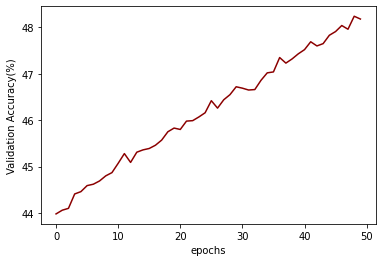

나의 최고 test accuracy :  48.2400016784668


In [ ]:
from matplotlib import pyplot as plt

plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')

plt.plot(range(epoch_size),history['val_acc'], label='정확도(%)', color='darkred')
plt.show()

print("나의 최고 test accuracy : ",max(history['val_acc']))